In [1]:
%matplotlib notebook

import numpy as np
import matplotlib
from glob import glob
import matplotlib.pyplot as plt
from scipy.special import softmax
from tabulate import tabulate
import collections
from tqdm import tqdm
import texttable, latextable
from uncertainty_metrics.numpy import ece

workdir = '.'

In [2]:
def get_prior(split):
    assert split in ('train', 'val', 'test')
    l = []
    for line in open(f'data/ImageNet_LT/ImageNet_LT_{split}.txt').readlines():
        l.append(int(line.strip().split()[-1]))
    ret = np.zeros(max(l)+1)
    for x in l:
        ret[x] += 1
    return ret / ret.sum()

In [14]:
def class_distribution(name, img_max=50, class_total=1000):
    cls_idx = get_prior('train').argsort()    
    def imb(imb_factor, reverse):
        img_num_per_cls = np.zeros_like(cls_idx)
        for idx, cls in enumerate(cls_idx[::-1]):
            if reverse:
                num = img_max * (imb_factor**((class_total - 1 - idx) / (class_total - 1.0)))
            else:
                num = img_max * (imb_factor**(idx / (class_total - 1.0)))
            img_num_per_cls[cls] = num  
        return img_num_per_cls
        
    
    rand_machine = np.random.RandomState(seed=1)
    distrb = {
        'uniform': np.array([img_max] * class_total),
        'forward-50': imb(0.02, False),
        'forward-25': imb(0.04, False),
        'forward-10': imb(0.1, False),
        'forward-5': imb(0.2, False),
        'forward-2': imb(0.5, False),
        'backward-50': imb(0.02, True),
        'backward-25': imb(0.04, True),
        'backward-10': imb(0.1, True),
        'backward-5': imb(0.2, True),
        'backward-2': imb(0.5, True),
    }[name]
    return distrb, distrb / distrb.sum()


def get_mask(labels, distrb):
    distrb = np.array(distrb)
    mask = np.zeros_like(labels).astype(bool)
    for i, label in enumerate(labels):
        if distrb[label] > 0:
            distrb[label] -= 1
            mask[i] = True
    return mask


def get_prob(logits, prior, name):
    old_prior = get_prior('train')
    source_logprior = np.log(old_prior)
    target_logprior = np.log(prior)
    if 'pc_' in name or 'lade' in name:
        return softmax(logits + target_logprior, axis=1)
    elif 'bs' in name or 'causal' in name:
        return softmax(logits, axis=1)
    else:
        return softmax(logits + source_logprior, axis=1)

def get_labels(name, split='test'):
    if 'pc_' in name:
        name = name[3:]
    path = f'{workdir}/lade21-lade/checkpoints/imagenet'
    return {
        'bs': np.load(f"{path}/bs/{split}_total_labels.npy"),
        'causal': np.load(f"{path}/causal/{split}_total_labels.npy"),
        'softmax': np.load(f"{path}/ce/{split}_total_labels.npy"),
        'lade': np.load(f"{path}/lade/{split}_total_labels.npy"),
    }[name]

def get_logits(name, split='test'):
    if 'pc_' in name:
        name = name[3:]
    path = f'{workdir}/lade21-lade/checkpoints/imagenet'
    return {
        'bs': np.load(f"{path}/bs/{split}_total_logits.npy") - np.log(get_prior('test')),
        'causal': np.load(f"{path}/causal/{split}_total_logits.npy") - np.log(get_prior('test')),
        'softmax': np.load(f"{path}/ce/{split}_total_logits.npy"),
        'lade': np.load(f"{path}/lade/{split}_total_logits.npy") - np.log(get_prior('test')),
    }[name]

# Evaluate on shifted test set

In [16]:
methods = ['bs', 'causal', 'softmax', 'pc_bs', 'pc_causal', 'pc_softmax', 'lade']
table = []
for dataset in tqdm([
    'forward-50', 'forward-25', 'forward-10', 'forward-5', 'forward-2',
    'uniform',
    'backward-2', 'backward-5', 'backward-10', 'backward-25', 'backward-50',
]):
    table.append([dataset])
    for method in methods:
        distrb, prior = class_distribution(dataset)
        labels = get_labels(method)
        estims = get_prob(get_logits(method), prior, method).argmax(1)
        mask = get_mask(labels, distrb)
        table[-1].append((labels[mask] == estims[mask]).mean() * 100)

print(tabulate(table, headers=['dataset'] + methods, floatfmt=".1f"))


100%|██████████| 11/11 [06:16<00:00, 34.23s/it]

dataset        bs    causal    softmax    pc_bs    pc_causal    pc_softmax    lade
-----------  ----  --------  ---------  -------  -----------  ------------  ------
forward-50   62.5      64.1       66.3     65.5         66.7          66.6    67.4
forward-25   60.9      62.5       63.9     63.1         64.3          63.9    64.8
forward-10   58.8      60.1       60.4     59.9         60.9          60.6    61.3
forward-5    57.0      57.8       57.1     57.3         58.1          58.1    58.6
forward-2    54.4      54.6       52.3     54.3         54.6          55.0    55.2
uniform      52.1      52.0       48.2     52.1         52.0          52.8    53.0
backward-2   49.6      49.3       44.2     50.2         49.8          51.0    51.2
backward-5   46.5      45.8       38.9     48.8         47.9          49.3    49.8
backward-10  44.1      43.4       35.0     48.3         47.0          48.8    49.2
backward-25  41.4      40.4       30.5     48.5         46.7          48.5    49.3
back

# Evaluate confidence calibration

In [20]:
from uncertainty_metrics.numpy import ece

def brier(labels, probs):
    confids = probs[np.arange(len(labels)), labels]
    return (np.square(probs).sum(1) - 2 * confids + 1).mean()

def nll(labels, probs):
    confids = probs[np.arange(len(labels)), labels]
    confids = np.clip(confids, 1e-15, 1.)
    return np.mean(-np.log(confids))

def accuracy(labels, probs):
    return (probs.argmax(1) == labels).mean()

prior = get_prior('test')

method_names = {
    'softmax': 'Softmax',
    "pc_softmax": "PC Softmax",
    "bs": "Balanced Softmax",
    "causal": "Causal Norm",
    "lade": "LADE",
}

for plt_index, method in enumerate(['softmax', 'causal', 'bs', 'pc_softmax', 'lade']):
    labels = get_labels(method)
    probs = get_prob(get_logits(method), prior, method)    
    print(f'{method_names[method]:30s} & {accuracy(labels, probs)*100:.1f} & {ece(labels, probs, num_bins=20):.3f} & {brier(labels, probs):.3f} & {nll(labels, probs):.2f} \\\\')


Softmax                        & 48.2 & 0.140 & 0.688 & 2.47 \\
Causal Norm                    & 52.0 & 0.108 & 0.634 & 2.42 \\
Balanced Softmax               & 52.1 & 0.061 & 0.621 & 2.20 \\
PC Softmax                     & 52.8 & 0.057 & 0.615 & 2.17 \\
LADE                           & 53.0 & 0.035 & 0.611 & 2.18 \\


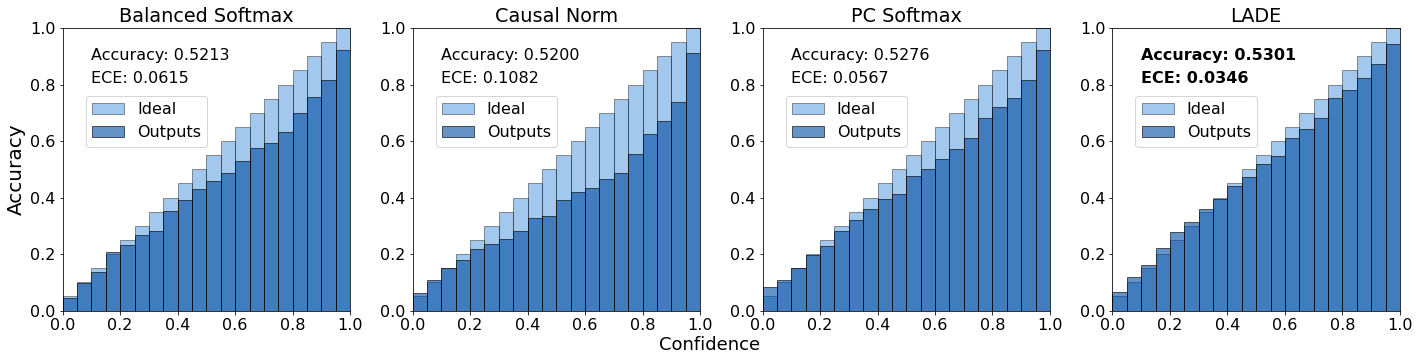

In [27]:
%matplotlib inline

old_prior = get_prior('train')
prior = get_prior('test')

matplotlib.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=False, sharex=True)

method_names = {
    "pc_softmax": "PC Softmax",
    "bs": "Balanced Softmax",
    "causal": "Causal Norm",
    "lade": "LADE",
}

methods = ['bs', 'causal', 'pc_softmax', 'lade']
for plt_index, method in enumerate(methods):
    labels = get_labels(method)
    probs = get_prob(get_logits(method), prior, method)
    estims = probs.argmax(1)

    confids = []
    step = 0.05
    for i in np.arange(0, 1, step):
        mask = (i < probs.max(1)) & (probs.max(1) <= i + step)
        if np.sum(mask) == 0:
            confids.append(0.0)
        else:
            confids.append((estims[mask] == labels[mask]).mean())
    axes[plt_index].bar(np.arange(0, 1, step), np.arange(step, 1+step, step), color="#1976d2", width=step, edgecolor='black', align='edge', alpha=0.4, label='Ideal')
    axes[plt_index].bar(np.arange(0, 1, step), confids, width=step, color="#004ba0", edgecolor='black', align='edge', alpha=0.6, label='Outputs')
    ece_val = ece(labels, probs, num_bins=20)
    
    axes[plt_index].set_ylim(0, 1)
    axes[plt_index].set_xlim(0, 1)
    axes[plt_index].legend(loc=(0.08, 0.58))

    acc = (labels == estims).mean()
    if method == 'lade':
        axes[plt_index].set_title(method_names[method])
        axes[plt_index].text(0.1, 0.85, f'ECE: {ece_val:.4f}', {'color': 'black', 'fontsize': 16}, va="top", ha="left", weight='bold')
        axes[plt_index].text(0.1, 0.93, f'Accuracy: {acc:.4f}', {'color': 'black', 'fontsize': 16}, va="top", ha="left", weight='bold')
    else:
        axes[plt_index].set_title(method_names[method])
        axes[plt_index].text(0.1, 0.85, f'ECE: {ece_val:.4f}', {'color': 'black', 'fontsize': 16}, va="top", ha="left")
        axes[plt_index].text(0.1, 0.93, f'Accuracy: {acc:.4f}', {'color': 'black', 'fontsize': 16}, va="top", ha="left")
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    
    if plt_index == 0:
#         axes[plt_index].legend(loc=(0.08, 0.63))
        axes[plt_index].set_ylabel('Accuracy', fontsize=20)

fig.text(0.5, 0.0, 'Confidence', {'color': 'black', 'fontsize': 18}, ha='center')
plt.tight_layout()
plt.show()

fig.savefig("4_ImageNet_Confidence_Calibration.pdf")